<a href="https://colab.research.google.com/github/tvpian/Foundation_Models/blob/main/GenAI_GAN_Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Advanced GAN

In [1]:
# Importing the Libraries
import torch , torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [36]:
def show(tensor, num = 25, wandb = 0, name = ''):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow = 5).permute(1,2,0)
  ##optional
  if wandb == 1 and wandbact == 1:
    wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})
  plt.imshow(grid.clip(0,1))
  plt.show()


## hypermeters and general parameters
n_epochs = 10000
batch_size = 128
lr = 1e-4
z_dim = 200
device = 'cuda'

cur_step = 0
crit_cycles = []
gen_losses = []
crit_losses = []
show_step = 35
save_step = 35


wandbact = 1




In [3]:
### Libraries to communicate with WANDB

!pip install wandb -qqq
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


In [4]:
wandb.login(key="c47eb3707f8ec450c0120e554ba97982c29cfa53")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
%%capture
experiment_name = wandb.util.generate_id()

myrun = wandb.init(
    project = "tvp_wgan",
    group = experiment_name,
    config = {
        "optimizer":"adam",
        "model":"wgan gp",
        "epoch":"1000",
        "batch_size":128
    }
)
config=wandb.config



In [6]:
print(experiment_name)


h7aqv7gm


In [7]:
# Generator model
class Generator(nn.Module):
  def __init__(self, z_dim = 64, d_dim = 16):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
        # ConvTranspose2d: in_channels, out_channels, kernel_size, stride = 1, padding = 0
        # Calculating new width and height: (n-1)*stride - 2*padding + ks
        # n - width or height
        # ks - kernel size
        # input -  1x1 image with z_dim number of channels(200)
        nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0),  ## 4x4 (ch:200, 512)
        nn.BatchNorm2d(d_dim * 32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1), ## 8x8 (ch:512, 256)
        nn.BatchNorm2d(d_dim * 32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1), ## 16x16 (ch:256, 128)
        nn.BatchNorm2d(d_dim * 16),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1), ## 32x32 (ch:128, 64)
        nn.BatchNorm2d(d_dim * 8),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1), ## 64x64 (ch:64, 32)
        nn.BatchNorm2d(d_dim * 4),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1), ## 128x128 (ch:32, 3)
        nn.Tanh() ## Get the results in the range of -1 and 1 preferred for Generative models
    )

  def forward(self, noise):
    x = noise.view() # 128 x 200 x 1 x 1
    return self.gen(x)

  def gen_noise(num, z_dim, device = "cuda"):
    return torch.rand(num, z_dim, device = "cuda") # 128 x 200


In [8]:
## Critic model
# conv2d: in_channel, out_channels, kernel_size, stride = 1, padding = 0
## New_width and height: # (n+2*pad-ks)//stride + 1

class Critic(nn.Module):
  def __init__(self, d_dim=16):
    super(Critic, self).__init__()

    self.crit = nn.Sequential(
        # Conv2d: in_channels, out_channels, kernel_size, stride = 1, padding = 0
        ## New width and height: # (n+2*pad-ks)//stride + 1
        nn.Conv2d(3, d_dim, 4, 2, 1), #(n+2*pad-ks)//stride + 1 - (128+2*1-4)//2+1 = 64 x 64 (ch: 3, 16)
        nn.InstanceNorm2d(d_dim), # Normalization by instance seemed to work the best
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim, d_dim*2, 4, 2 ,1), ## 32x32 (ch: 16, 32)
        nn.InstanceNorm2d(d_dim*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*2, d_dim*4, 4, 2 ,1), ## 16x16 (ch: 32, 64)
        nn.InstanceNorm2d(d_dim*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*4, d_dim*8, 4, 2 ,1), ## 8x8 (ch: 64, 128)
        nn.InstanceNorm2d(d_dim*8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*8, d_dim*16, 4, 2 ,1), ## 4x4 (ch: 128, 256)
        nn.InstanceNorm2d(d_dim*16),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*16, 1, 4, 1 ,0), ## 1x1 (ch: 256, 1)
    )

  def forward(self, image):
    # image : 128 x 3 x 128 x 128
    crit_pred = self.crit(image) # 128 x 1 x 1 x 1
    return crit_pred.view(len(crit_pred), -1) # 128 x 1

In [9]:
# Optional, init your weights in different ways
def init_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weights, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

# gen = generator.apply(init_weights)

In [19]:
# load dataset
import gdown, zipfile

url = 'https://drive.google.com/drive/folders/1b4BhHEOV338vvq1w9bwcWIZQN8XbOn02'
path='data/celeba'
download_path=f'{path}/img_align_celeba.zip'

if not os.path.exists(path):
  os.makedirs(path)

gdown.download(url, download_path, quiet=False, fuzzy = "True" )



Downloading...
From: https://drive.google.com/drive/folders/1b4BhHEOV338vvq1w9bwcWIZQN8XbOn02
To: /content/data/celeba/img_align_celeba.zip
1.21MB [00:00, 74.2MB/s]


'data/celeba/img_align_celeba.zip'

In [16]:
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(path)

BadZipFile: File is not a zip file

In [20]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
with zipfile.ZipFile("/content/drive/MyDrive/ML_DATASETS/img_align_celeba.zip", 'r') as ziphandler:
  ziphandler.extractall(path)

In [30]:
class Dataset(Dataset):
  def __init__(self, path, size = 128, lim = 10000):
    self.sizes=[size, size]
    items, labels = [], []

    for data in os.listdir(path)[:lim]:
      item = os.path.join(path,data)
      items.append(item)
      labels.append(data)
    self.items = items
    self.labels = labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB') # 128,128
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # 128 x 128 x 3
    data = np.transpose(data, (2,0,1)).astype(np.float32, copy = False) # 3 x 128 x 128
    data = torch.from_numpy(data).div(255) # Converting images from 0 to 255 - 0 to 1
    return data, self.labels[idx]



In [31]:
device = "cpu"

In [32]:
# Instantiate the dataset
data_path = "/content/data/celeba/img_align_celeba"
ds = Dataset(data_path, size = 128, lim = 10000)

In [33]:
# Declare the Dataloader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle = True)

# Model declaration
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

# Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr, betas = (0.5,0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr = lr, betas = (0.5,0.9))

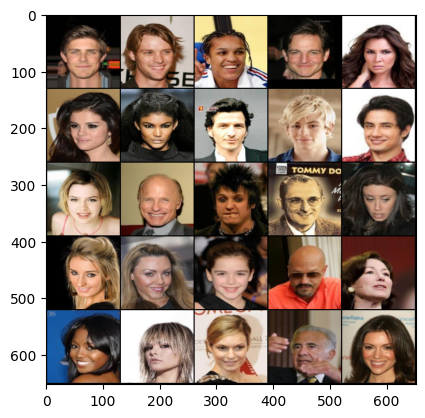

In [37]:
#wandb optional
if wandbact == 1:
  wandb.watch(gen, log_freq = 100)
  wandb.watch(crit, log_freq = 100)

x,y = next(iter(dataloader))
show(x)

In [ ]:
# Gradient penalty calculation

def calculate_gp(real, fake, crit, a)